# percent-allocate

Maintain a percent allocation of a security in account

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

Define target_percent and band

In [5]:
target_percent = 100
band = 3

sma200_band = 3.5/100

Define Strategy Class 

In [6]:
class Strategy:

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        pf.TradeLog.cash = self._capital

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self._ts, i)
            shares = 0

            # adjust shares
            if ((self._tlog.share_percent(close) > target_percent+band or
                self._tlog.share_percent(close) < target_percent-band)
                and close > row.sma200*(1+sma200_band)
                and not end_flag):
                # adjust shares to target_percent
                shares = self._tlog.adjust_percent(date, close, target_percent)   
            # close out
            elif (close < row.sma200*(1-sma200_band)
                  or end_flag):
                # adjust shares to 0
                shares = self._tlog.adjust_percent(date, close, 0)

            if shares > 0:
                pf.DBG("{0} BUY  {1} {2} @ {3:.2f}".format(
                       date, shares, self._symbol, close))
            elif shares < 0:
                pf.DBG("{0} SELL {1} {2} @ {3:.2f}".format(
                       date, -shares, self._symbol, close))

            # record daily balance
            self._dbal.append(date, high, low, close)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end,
                                         use_adj=True, pad=False)

        # Add technical indicator: 200 day sma
        sma200 = SMA(self._ts, timeperiod=200)
        self._ts['sma200'] = sma200
        
        self._ts, self._start = pf.finalize_timeseries(self._ts, self._start)

        self._tlog = pf.TradeLog(self._symbol)
        self._dbal = pf.DailyBal()

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self._tlog.get_log_raw()
        self.tlog = self._tlog.get_log()
        self.dbal = self._dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self._ts, self.tlog, self.dbal, self._capital)
        return stats

Run Strategy

In [7]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [8]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [9]:
rlog.tail(10)

,date,price,shares,entry_exit,direction,symbol
12,2010-09-24,94.38,484,entry,LONG,SPY
13,2011-08-04,100.30,484,exit,LONG,SPY
14,2012-01-10,108.94,445,entry,LONG,SPY
15,2015-08-21,179.10,445,exit,LONG,SPY
16,2016-04-01,190.40,418,entry,LONG,SPY
17,2018-10-29,254.83,418,exit,LONG,SPY
18,2019-03-18,275.46,387,entry,LONG,SPY
19,2020-03-09,271.43,387,exit,LONG,SPY
20,2020-06-03,310.81,338,entry,LONG,SPY
21,2020-07-14,316.03,338,exit,LONG,SPY


In [10]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
1,1994-08-26,29.49,1998-08-31,64.18,34.69,11274.33,325,10862.24,LONG,SPY
2,1998-11-02,75.06,1999-10-15,84.76,9.70,2686.09,277,13548.32,LONG,SPY
3,1999-10-29,92.99,2000-10-10,94.38,1.39,352.13,253,13900.45,LONG,SPY
4,2003-04-22,64.88,2007-11-21,109.00,44.13,16238.76,368,30139.20,LONG,SPY
5,2009-06-05,75.43,2010-06-07,85.84,10.42,5541.00,532,35680.20,LONG,SPY
6,2010-09-24,94.38,2011-08-04,100.30,5.92,2864.27,484,38544.47,LONG,SPY
7,2012-01-10,108.94,2015-08-21,179.10,70.16,31222.77,445,69767.24,LONG,SPY
8,2016-04-01,190.40,2018-10-29,254.83,64.42,26928.83,418,96696.07,LONG,SPY
9,2019-03-18,275.46,2020-03-09,271.43,-4.03,-1560.41,387,95135.66,LONG,SPY
10,2020-06-03,310.81,2020-07-14,316.03,5.22,1763.61,338,96899.27,LONG,SPY


In [11]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-07-08,106990.52,105773.73,106949.97,338,81.13,1.00,-
2020-07-09,107260.93,105090.97,106341.57,338,81.13,1.00,-
2020-07-10,107524.57,105794.01,107426.55,338,81.13,1.00,-
2020-07-13,109157.11,106257.07,106497.05,338,81.13,1.00,-
2020-07-14,106899.27,106899.27,106899.27,0,106899.27,0.00,X


Generate strategy stats - display all available stats

In [12]:
pf.print_full(stats)

start                                                  1993-11-11
end                                                    2020-07-14
beginning_balance                                           10000
ending_balance                                          106899.27
total_net_profit                                         96899.27
gross_profit                                             98871.78
gross_loss                                               -1972.51
profit_factor                                               50.12
return_on_initial_capital                                  968.99
annual_return_rate                                           9.29
trading_period                           26 years 8 months 3 days
pct_time_in_market                                          75.19
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

Run Benchmark

In [13]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()

1993-11-11 00:00:00 BUY  215 SPY @ 46.38
2020-07-14 00:00:00 SELL 215 SPY @ 316.03


Retrieve benchmark logs

In [14]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [15]:
benchmark.stats = benchmark.get_stats()
pf.print_full(benchmark.stats)

start                                                  1993-11-11
end                                                    2020-07-14
beginning_balance                                           10000
ending_balance                                           67975.82
total_net_profit                                         57975.82
gross_profit                                             57975.82
gross_loss                                                   0.00
profit_factor                                                1000
return_on_initial_capital                                  579.76
annual_return_rate                                           7.45
trading_period                           26 years 8 months 3 days
pct_time_in_market                                         100.00
margin                                                          1
avg_leverage                                                 1.00
max_leverage                                                 1.00
min_levera

Plot Equity Curves: Strategy vs Benchmark

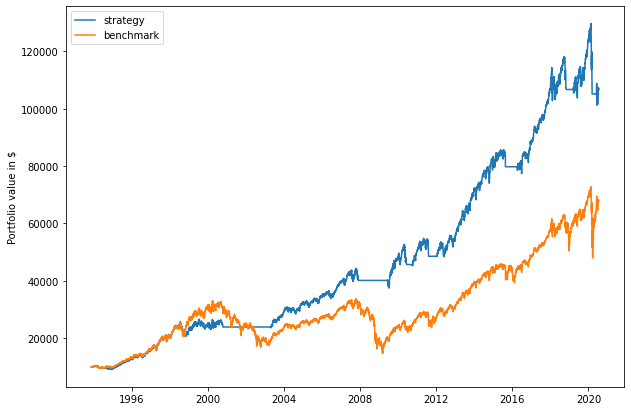

In [16]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

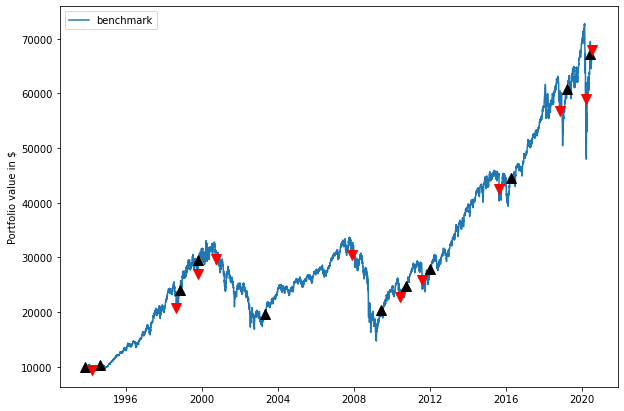

In [17]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,9.29,7.45
max_closed_out_drawdown,-21.94,-56.42
drawdown_annualized_return,-2.36,-7.57
drawdown_recovery,-0.31,-1.42
best_month,15.45,23.06
worst_month,-18.94,-31.38
sharpe_ratio,0.78,0.47
sortino_ratio,0.85,0.60
monthly_std,3.15,4.54


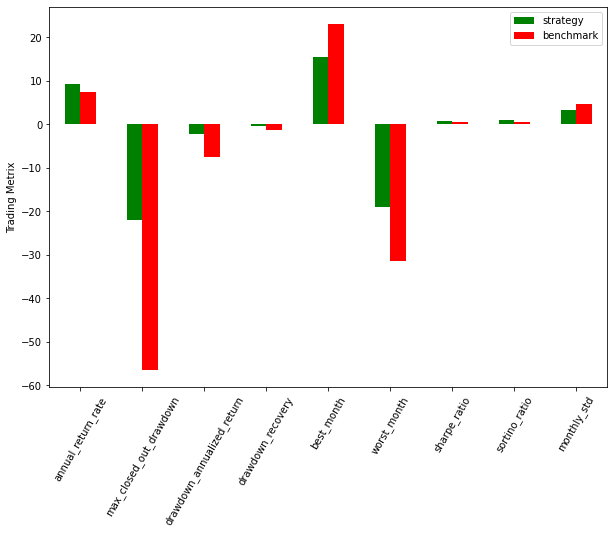

In [18]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df